In [1]:
# Imports
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%dotenv

import os
from collections import Counter

from graphdatascience import GraphDataScience
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/home/ec2-user/miniconda3/envs/rnalab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Config

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')

DATA_DIR = '/mnt/graphdata/lpa/'
FEATURES_DIR = '/mnt/graphdata/features/community'

METADATA_PROJECTION_NAME = 'metadata-fts'
METADATA_TYPE = 'tissue' # 'tissue' or 'taxon'
MAX_HIERARCHY_LEVEL = 1
RANDOM_SEED = 42

In [9]:
# Db helpers

def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def query_gds(query):
    client = get_gds_client()
    return client.run_cypher(query)

In [10]:
# Data helpers

def get_tissue_nodes():
    if os.path.exists(f'{DATA_DIR}/all_tissues.csv'):
        return pd.read_csv(f'{DATA_DIR}/all_tissues.csv', index_col=False)
    query = f"""
        MATCH (t:Tissue)
        RETURN 
            id(t) as nodeId, 
            t.btoId as btoId,
            t.scientificName as scientificName
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/all_tissues.csv', index=False)
    return df

def get_tissue_edges():
    if os.path.exists(f'{DATA_DIR}/tissue_edges.csv'):
        return pd.read_csv(f'{DATA_DIR}/tissue_edges.csv', index_col=False)
    query = f"""
        MATCH (t:Tissue)-[r:HAS_PARENT]->(t2:Tissue)
        RETURN 
            id(t) as sourceNodeId,
            id(t2) as targetNodeId,
            t.btoId as sourceBtoId,
            t2.btoId as targetBtoId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/tissue_edges.csv', index=False)
    return df


def get_taxon_nodes():
    if os.path.exists(f'{DATA_DIR}/taxon_nodes.csv'):
        return pd.read_csv(f'{DATA_DIR}/taxon_nodes.csv', index_col=False)
    query = """
        MATCH (t:Taxon)
        RETURN 
            id(t) as nodeId,
            t.taxId as appId,
            t.taxId as taxId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/taxon_nodes.csv', index=False)
    return df


def get_virus_taxon_nodes():
    if os.path.exists(f'{DATA_DIR}/virus_taxon_nodes.csv'):
        return pd.read_csv(f'{DATA_DIR}/virus_taxon_nodes.csv', index_col=False)
    query = """
        MATCH (t:Taxon)
        WHERE (t)-[:HAS_PARENT*]->(:Taxon {taxId: '10239'})
        OR t.taxId = '10239'
        RETURN 
            id(t) as nodeId, 
            t.taxId as taxId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/virus_taxon_nodes.csv', index=False)
    return df

def get_virus_taxon_edges():
    if os.path.exists(f'{DATA_DIR}/virus_taxon_edges.csv'):
        return pd.read_csv(f'{DATA_DIR}/virus_taxon_edges.csv', index_col=False)
    query = """
        MATCH (t:Taxon)-[r:HAS_PARENT]->(t2:Taxon)
        WHERE (t)-[:HAS_PARENT*]->(:Taxon {taxId: '10239'})
        OR t.taxId = '10239'
        RETURN 
            id(t) as sourceNodeId,
            id(t2) as targetNodeId,
            t.taxId as sourceTaxId,
            t2.taxId as targetTaxId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/virus_taxon_edges.csv', index=False)
    return df




In [11]:
# Community detection

def get_wcc_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.wcc.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
    )
    return communities

def get_scc_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.scc.stream(
        graph,
    )
    return communities

def get_louvain_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.louvain.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
        includeIntermediateCommunities=False,
        maxIterations=100,
        maxLevels=MAX_HIERARCHY_LEVEL,
        tolerance=0.1,
        consecutiveIds=False,
    )
    return communities

def get_leiden_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.leiden.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
        minCommunitySize=1,
        maxLevels=MAX_HIERARCHY_LEVEL,
        theta=0.01,
        gamma=1.0,
        includeIntermediateCommunities=True,
        consecutiveIds=False,
    )
    return communities

def get_modularity_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.modularityOptimization.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
        tolerance=0.000001,
        maxIterations=100,
    )
    return communities

def get_kcut_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.maxkcut.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        # randomSeed=RANDOM_SEED,
        k=127,
        iterations=100,
    )
    return communities

def get_lpa_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.labelPropagation.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
        maxIterations=100,
    )
    return communities

def get_speaker_listener_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.sllpa.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
        maxIterations=100,
        minAssociationStrength=0.5,
        partitioning="RANGE",
    )
    return communities

def plot_communities(communities):
    community_sizes = communities.groupby('communityId').size()
    num_unique_communities = len(community_sizes)
    community_sizes = pd.Series(community_sizes)
    community_sizes = community_sizes.sort_values(ascending=False)
    print(community_sizes)
    # plot top 10 largest communities
    plt.figure(figsize=(15, 6))
    top_n = 100
    community_sizes.plot(kind='bar')
    plt.xlabel('Community ID')
    plt.ylabel('Number of sOTUs')
    plt.title(f'Distribution of top {top_n}/{num_unique_communities} sOTU community sizes')
    # show every 5th tick
    plt.xticks(np.arange(0, top_n, 5))
    plt.show()


def plot_communities_histogram(communities):
    community_sizes = communities.groupby('communityId').size()
    community_sizes = pd.Series(community_sizes)
    community_sizes = community_sizes.sort_values(ascending=False)
    plt.figure(figsize=(15, 6))
    community_sizes.plot(kind='hist')
    plt.xlabel('Number of sOTUs in community')
    plt.ylabel('Number of communities')
    plt.title(f'Distribution of sOTU community sizes')
    plt.yscale('log')
    plt.show()


In [6]:
# Create projection

tissue_query = '''
    MATCH (source)
    WHERE source:Tissue
    OPTIONAL MATCH (source)-[r:HAS_PARENT]->(target)
    WHERE target:Tissue
    WITH gds.graph.project(
        'metadata-fts',
        source,
        target,
        {
        },
        {
            undirectedRelationshipTypes: ['*']
        }
    ) as g
    RETURN g
'''

taxon_query = '''
    MATCH (source)
    WHERE source:Taxon
    OPTIONAL MATCH (source)-[r:HAS_PARENT]->(target)
    WHERE target:Taxon
    WITH gds.graph.project(
        'metadata-fts',
        source,
        target,
        {
        },
        {
            undirectedRelationshipTypes: ['*']
        }
    ) as g
    RETURN g
'''


gds = get_gds_client()

if gds.graph.exists(METADATA_PROJECTION_NAME)['exists']:
    gds.graph.drop(gds.graph.get(METADATA_PROJECTION_NAME))


if METADATA_TYPE == 'tissue':
    projection = query_gds(tissue_query)
elif METADATA_TYPE == 'taxon':
    projection = query_gds(taxon_query)

display(projection)

,g
0,"{'relationshipCount': 15292, 'graphName': 'met..."


In [12]:
# Run community analysis

gds = get_gds_client()
projection = gds.graph.get(METADATA_PROJECTION_NAME)
# communities = get_kcut_communities(projection)
# communities = get_modularity_communities(projection)
communities = get_leiden_communities(projection)
# communities = get_louvain_communities(projection)
# communities = get_lpa_communities(projection)
# communities = get_speaker_listener_communities(projection)

if 'componentId' in communities.columns:
    communities['communityId'] = communities['componentId']

# denormalize communities using values.communityIds for multi-community nodes
if 'values' in communities.columns:
    communities['values'] = communities['values'].apply(lambda x: x['communityIds'])
    communities = communities.explode('values')
    communities['communityId'] = communities['values']
    communities = communities.drop(columns=['values'])

In [13]:
if METADATA_TYPE == 'tissue':
    tissue_nodes = get_tissue_nodes()
    unique_labels = tissue_nodes.btoId.nunique()
    communities = communities.merge(tissue_nodes, left_on='nodeId', right_on='nodeId')
    communities = communities[[
        'nodeId',
        'btoId',
        'communityId',
        'intermediateCommunityIds',
    ]]
    communities = communities.rename(columns={'btoId': 'appId'})
elif METADATA_TYPE == 'taxon':
    taxon_nodes = get_taxon_nodes()
    unique_labels = taxon_nodes.taxId.nunique()
    communities = communities.merge(taxon_nodes, left_on='nodeId', right_on='nodeId')
    communities = communities[[
        'nodeId',
        'taxId',
        'communityId',
        'intermediateCommunityIds',
    ]]
    communities = communities.rename(columns={'taxId': 'appId'})

print(f'Unique labels: {unique_labels} reduced to {communities.communityId.nunique()} communities')
print(communities.communityId.value_counts())
print(communities.communityId.value_counts().describe())

Unique labels: 6569 reduced to 1623 communities
5       290
821     121
475      39
459      38
2676     37
       ... 
5432      1
5433      1
5472      1
6158      1
5960      1
Name: communityId, Length: 1623, dtype: int64
count    1623.000000
mean        4.047443
std         8.538061
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max       290.000000
Name: communityId, dtype: float64


In [18]:
print(communities.head())
# if METADATA_TYPE == 'tissue':
#     communities.to_csv(f'{FEATURES_DIR}/tissue_leiden_communities.csv', index=False)
# elif METADATA_TYPE == 'taxon':
#     communities.to_csv(f'{FEATURES_DIR}/taxon_leiden_communities.csv', index=False)

    nodeId  appId  communityId             intermediateCommunityIds
0  8755885     54         1991    [343324, 48240, 2366, 1073, 1991]
1  9655883     53         1991     [82093, 48240, 2366, 1073, 1991]
2  8755886     59         2576  [166501, 165598, 13491, 7456, 2576]
3  9850834    481         2576  [586161, 146490, 13491, 7456, 2576]
4  8755887    317          730      [12874, 38325, 8619, 1715, 730]


communityId
5       290
821     121
475      39
459      38
2676     37
       ... 
3374      1
6158      1
594       1
601       1
6396      1
Length: 1623, dtype: int64


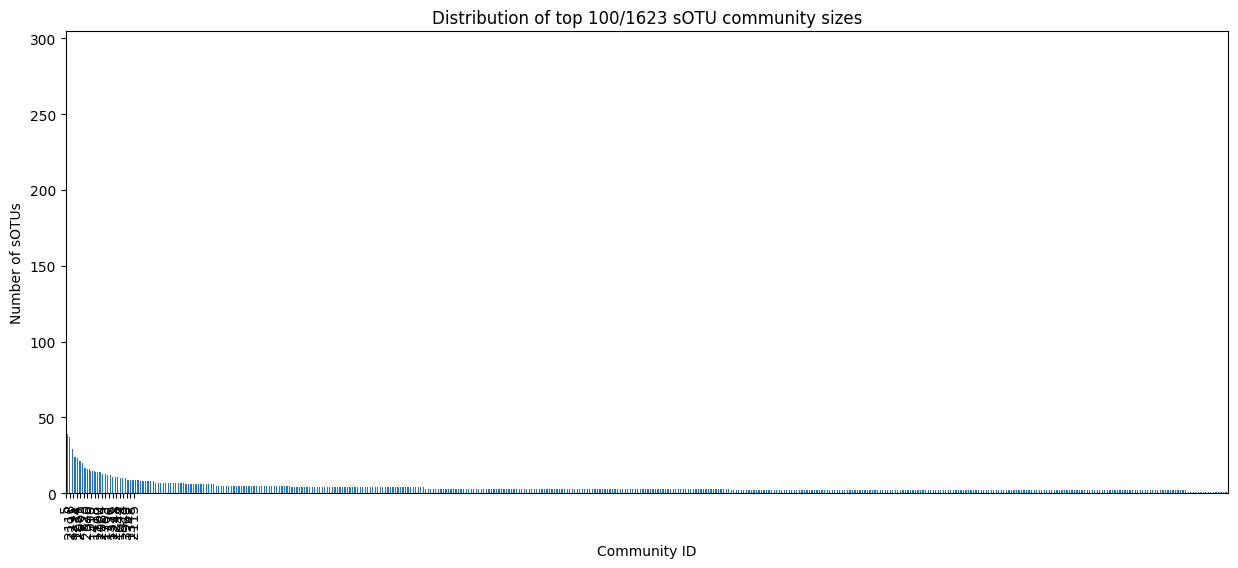

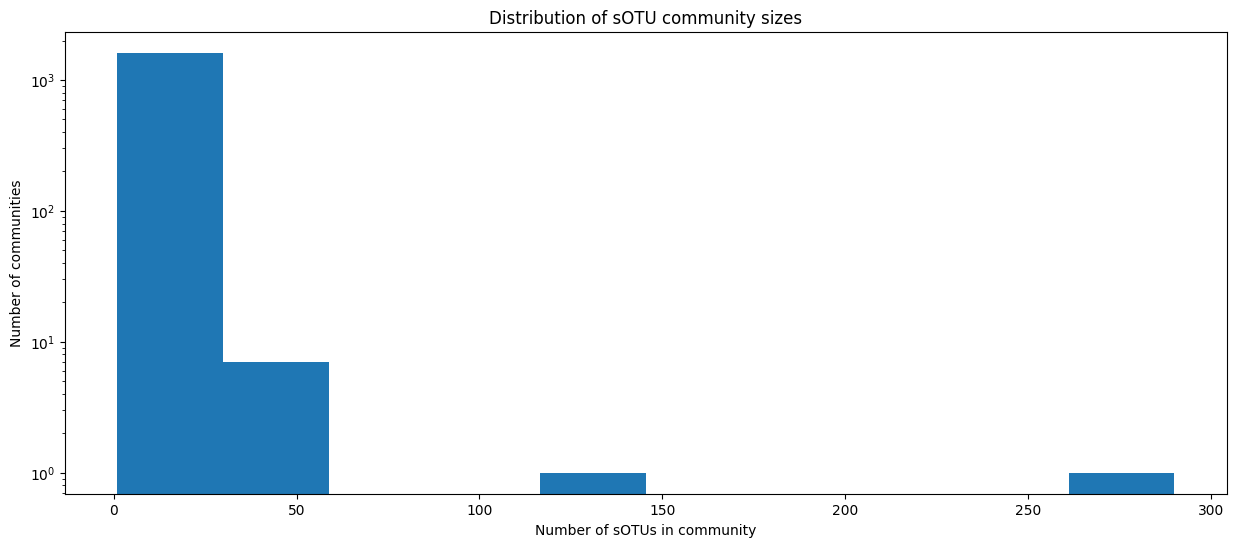

In [14]:
plot_communities(communities)
plot_communities_histogram(communities)

In [15]:
val_dict = {
    "skin": [
        "skin",
        "adipose tissue",
        "epithelium",
        "dermis", "epidermis",
        "connective tissue",
        "integument", "mucosa", "ulcer tissue", 
        "head", "mouth", 
    ],
    "gland": [
        "gland",
        "endocrine gland", "pancreas"
    ],
    "cancer": [
        "cancer",
        "skin cancer cell", "epithelioma cell",
        "adenoma cell", "carcinoma cell",
        "derived cell line",
        "fibroblast",
    ],
    "embryonic structure": [
        "embryonic structure",
        "pluripotent stem cell"
    ],
    "cardiovascular system": [
        "cardiovascular system",
        "heart", "atrium", "heart ventricle", "vascular system", "artery", "aorta", "vein",
        "blood", "blood plasma", "endothelium", "liver",
    ],
    "hematopoietic system": [
        "hematopoietic system",
        "hematopoietic cell", "erthrocyte", "leukocyte", "monocyte", "macrophage", "lymphocyte", "t cell", "b cell", "natural killer cell",
        "granulocyte", "neutrophil", "basophil", "eosinophil", "blood platelet", "lymphoid tissue"
    ],
    "nervous system": [
        "nervous system",
        "brain", "glia", "forebrain", 
        "stem",
    ],
    "limb": [
        "limb", "forelimb", "arm", "leg", "trunk", "thorax", "breast", "viscus"
    ],
    "muscular system": [
        "muscular system",
        "muscle", "skeletal muscle", "muscle fibre", "myocyte"
    ],
    "skeletal system": [
        "skeletal system",
        "bone", "bone marrow"
    ],
    "respiratory system": [
        "respiratory system",
        "lung"
    ],
    "urogenital system": [
        "urogenital system",
        "bladder", "urinary bladder", "kidney"
    ],
    "reproductive system": [
        "reproductive system",
        "female reproductive system", "ovary", "oviduct", "vagina", "uterus", "cervix",
        "male reproductive system", "prostate gland"
    ],
    "gastrointestinal tract": [
        "gastrointestinal tract",
        "tooth", "mouth", "alimentary canal", "esophagus", 
        "intestine", "small intestine", "large intestine",
        "stomach", "gut", "foregut", "midgut", "hindgut",
        "gall bladder", "spleen", "anus", "feces",
    ],
    "whole plant": [
        "whole plant",
        "fruit",
        "shoot",
        "leaf",
        "root",
        "fungus",
        "fruit body",
    ]
}

tissue_nodes = get_tissue_nodes()

community_stats = {}
# check all validation groups in same community
for key, vals in val_dict.items():
    community_counter = Counter()
    for val in vals:
        tissue_row = tissue_nodes[
            tissue_nodes['scientificName'] == val
        ]
        if tissue_row.empty:
            print(val)
            continue 
        tissue_node_id = tissue_row['nodeId'].values[0]
        community_row = communities.loc[
            communities['nodeId'] == tissue_node_id
        ]
        community_id = community_row['communityId'].values[0]
        community_counter[community_id] += 1

    community_stats[key] = community_counter

# display(community_stats)

# for each group in val_dict, get avg counter value
avg_community_stats = {}
for key, val in community_stats.items():
    avg_community_stats[key] = np.mean(list(val.values()))
display(avg_community_stats)

overall_avg = np.mean(list(avg_community_stats.values()))
display(overall_avg)

# get number of communities that are in more than one group
cross_group_community_counter = Counter()
for key, val in community_stats.items():
    for community_id in val.keys():
        cross_group_community_counter[community_id] += 1
# display(cross_group_community_counter)
# get avg number of groups that a community is in
avg_cross_group_community = np.mean(list(cross_group_community_counter.values()))
display(avg_cross_group_community)
        

cancer
derived cell line
erthrocyte
t cell
b cell
myocyte
cervix


{'skin': 1.1,
 'gland': 1.0,
 'cancer': 1.0,
 'embryonic structure': 1.0,
 'cardiovascular system': 1.0,
 'hematopoietic system': 1.3,
 'nervous system': 1.0,
 'limb': 1.0,
 'muscular system': 1.0,
 'skeletal system': 1.0,
 'respiratory system': 1.0,
 'urogenital system': 1.0,
 'reproductive system': 1.0,
 'gastrointestinal tract': 1.0625,
 'whole plant': 1.0}

1.0308333333333333

1.0206185567010309

In [19]:
#  display scientific name of tissues in communities

tissues_in_communities = communities
tissues_in_communities = tissues_in_communities.merge(
    tissue_nodes,
    how='left',
    left_on='nodeId',
    right_on='nodeId'
)
if 'communityId' in tissues_in_communities.columns:
    tissues_in_communities = tissues_in_communities.groupby('communityId')['scientificName'].apply(list)
    tissues_in_communities = tissues_in_communities.reset_index()
    display(tissues_in_communities)
else:
    denormalized_rows = []
    for row in communities.itertuples():
        tissue = tissue_nodes[tissue_nodes['nodeId'] == row.nodeId]['scientificName'].values[0]
        community_ids = row.values['communityIds']
        for community_id in community_ids:
            denormalized_rows.append({
                'scientificName': tissue,
                'communityId': community_id,
            })
    tissues_in_communities = pd.DataFrame(denormalized_rows)
    tissues_in_communities = tissues_in_communities.groupby('communityId')['scientificName'].apply(list)
    tissues_in_communities = tissues_in_communities.reset_index()
    display(tissues_in_communities)


top_communities = tissues_in_communities
top_communities['size'] = tissues_in_communities.scientificName.apply(len)
top_communities = top_communities.sort_values('size', ascending=False).head(100)['communityId'].values

for i in top_communities:
    vals = tissues_in_communities[tissues_in_communities['communityId'] == i]['scientificName'].values[0]
    # print(sorted(vals))
    print(i, vals)

,communityId,scientificName
0,5,"[culture condition:1,4-dichlorobenzene-grown c..."
1,12,"[osteoblastoma cell, osteoblast, osteogenic ce..."
2,26,"[3T3-L1 cell, NIH-3T3 cell, NIH-3T3-G185 cell,..."
3,37,"[A-431 cell, carcinoma cell line, transitional..."
4,63,"[pectoral muscle, thorax muscle, diaphragm]"
...,...,...
1618,6558,"[2fTGH cell, U-5A cell]"
1619,6559,"[SKOV-3 cell, SKOV3IP cell]"
1620,6563,"[adult liver stem cell, hepatic oval cell]"
1621,6565,"[RMA cell, RMA-S cell]"


5 ['culture condition:1,4-dichlorobenzene-grown cell', 'culture condition:-grown cell', 'culture condition:2,5-dihydroxybenzoate-grown cell', 'culture condition:2-aminobenzenesulfonate-grown cell', 'culture condition:3-chlorobenzoate-grown cell', 'culture condition:3-hydroxybenzoate-grown cell', 'culture condition:3-methylcrotonoyl-CoA-grown cell', 'culture condition:4-(methoxymethyl)phenol-grown cell', 'culture condition:4-chlorophenol-grown cell', 'culture condition:4-hydroxybenzoate-grown cell', 'culture condition:4-methylmuconolactone-grown cell', 'culture condition:galactose-grown cell', 'culture condition:ammonium malate-grown cell', 'culture condition:aniline-grown cell', 'culture condition:arabinose-grown cell', 'culture condition:benzoate-grown cell', 'culture condition:benzoylformate-grown cell', 'culture condition:butyrate-grown cell', 'culture condition:2-chloropropionate-grown cell', 'culture condition:galactonate-grown cell', 'culture condition:chlorobenzoate-grown cell',

In [53]:
#  drop projection
if gds.graph.exists(METADATA_PROJECTION_NAME)['exists']:
    gds.graph.drop(gds.graph.get(METADATA_PROJECTION_NAME))

## Graphistry Plot

In [37]:
import graphistry
graphistry.register(api=3, username=os.getenv('GRAPHISTRY_USERNAME'), password=os.getenv('GRAPHISTRY_PASSWORD'))

In [38]:
def get_graphistry_df(metadata_nodes, metadata_edges, communities):
    nodes = metadata_nodes.copy()
    nodes = nodes.reset_index()
    nodes = nodes.merge(
        communities[['nodeId', 'communityId']],
        on='nodeId', how='left'
    )
    nodes['communityId'] = nodes['communityId'].fillna(-1)
    nodes['communityIdStr'] = nodes['communityId'].astype(str)

    edges = metadata_edges.copy()
    edges = edges[
        edges['sourceNodeId'].isin(nodes['nodeId']) &
        edges['targetNodeId'].isin(nodes['nodeId'])
    ]

    edges['targetNodeId'] = edges['targetNodeId'].astype(str)
    edges['sourceNodeId'] = edges['sourceNodeId'].astype(str)
    edges['weight'] = '1'
    edges['weightInt'] = 1
    edges = edges[[
        'sourceNodeId', 'targetNodeId', 'weight', 'weightInt'
    ]].astype(str)
    edges['weightInt'] = edges['weightInt'].astype('int32')
    return nodes, edges

In [39]:
if METADATA_TYPE == 'tissue':
    metadata_nodes = get_tissue_nodes()
    metadata_edges = get_tissue_edges()
    metadata_nodes['displayLabel'] = metadata_nodes['scientificName']

if METADATA_TYPE == 'taxon':
    metadata_nodes = get_virus_taxon_nodes()
    metadata_edges = get_virus_taxon_edges()
    metadata_nodes['displayLabel'] = metadata_nodes['taxId']

nodes, edges = get_graphistry_df(metadata_nodes, metadata_edges, communities)

In [40]:
g = graphistry.bind()

g = g.bind(
    source='sourceNodeId',
    destination='targetNodeId',
    edge_weight='weightInt',
).edges(edges)

g = g.bind(
    node='nodeId',
    point_label='displayLabel',
    point_size=None,
    # point_size='numRuns',
).nodes(nodes)

params = {
    'play': 2000,
    'menu': True, 
    'info': True,
    'showArrows': True,
    'pointSize': 2.0, 
    # 'edgeCurvature': 0.5,
    'edgeOpacity': 0.25, 
    'pointOpacity': 1.0,
    # 'lockedX': False, 'lockedY': False, 'lockedR': False,
    'linLog': True, 
    'compactLayout': True,
    'strongGravity': True,
    'dissuadeHubs': False,
    'edgeInfluence': 5,
    # 'precisionVsSpeed': 0, 'gravity': 1.0, 'scalingRatio': 1.0,
    # 'showLabels': True, 'showLabelOnHover': True,
    # 'showPointsOfInterest': True, 'showPointsOfInterestLabel': True, 
    'showLabelPropertiesOnHover': True,
    'pointsOfInterestMax': 10,
}

g = g.settings(url_params=params)

g = g.addStyle(
    bg={
        'color': 'black',
})

# g = g.tree_layout()
# g = g.modularity_weighted_layout()

g = g.encode_point_color(
    'missing',
    categorical_mapping={},
    default_mapping='silver',
)


# g = g.encode_point_color(
#     'correct',
#     categorical_mapping={0: 'red', 1: 'green'},
# )

g.plot()

In [76]:
print(g)

{'bindings': {'edges':      sourceNodeId targetNodeId weight  weightInt
  0        11257759     11257760      1          1
  1        11257760     11258028      1          1
  2        11257761     11257762      1          1
  3        11257762     11257760      1          1
  4        11257763     11257764      1          1
  ...           ...          ...    ...        ...
  7641     11264322     11258780      1          1
  7642     11264323     11264322      1          1
  7643     11264324     11259856      1          1
  7644     11264325     11259856      1          1
  7645     11264326     11258868      1          1
  
  [7646 rows x 4 columns],
  'nodes':       index    nodeId        btoId  \
  0         0  11257758  BTO_0000000   
  1         1  11257759  BTO_0000001   
  2         2  11257760  BTO_0000216   
  3         3  11257761  BTO_0000002   
  4         4  11257762  BTO_0001479   
  ...     ...       ...          ...   
  6564   6564  11264322  BTO_0006562   
  6565  

   index    nodeId        btoId  \
0      0  11257758  BTO_0000000   
1      1  11257759  BTO_0000001   
2      2  11257760  BTO_0000216   
3      3  11257761  BTO_0000002   
4      4  11257762  BTO_0001479   

                                     scientificName  \
0            tissues, cell types and enzyme sources   
1                   culture condition:-induced cell   
2                                 culture condition   
3  culture condition:1,4-dichlorobenzene-grown cell   
4                     culture condition:-grown cell   

                                       displayLabel  communityId  \
0            tissues, cell types and enzyme sources      7684006   
1                   culture condition:-induced cell           59   
2                                 culture condition           59   
3  culture condition:1,4-dichlorobenzene-grown cell      7683937   
4                     culture condition:-grown cell      7683937   

  communityIdStr  
0        7684006  
1          